# <center>EMEA hackathon Q2 2020. Exploratory analysis</center>
### Description
Use of universal pixels are becoming more and more popular to improve efficiency and drive revenue. Universal pixel or tag is a code snippet which can be placed across a website and track users’ actions. This information collected from tracking can be used for tracking conversions or building audiences.

The goal of 2020 Q2 EMEA hackathon is to familiarise yourself with the data from universal pixel and make a prediction if a user is in a high value segment. The data comes from one of our clients. A high value segment is a group of users that are highly likely to take a specific action that is valuable to the client such as purchasing a product. Between these users there are commonalities that you could investigate to make your prediction.

### Data structure
| Field | Description |
|:-------|:-------------|
| **date_time** | The time and date of the universal pixel fire |
| **user_id_64** | User id |
| **url** |	The entire URL of the page the pixel is on |
| **http_referer** | The entire URL of the referrer to the page the pixel is on |
| **event**	| The event associated with the pixel fire |
| **item_ids**	| Strings passed in on the item_id parameter within your pixel |
| **item_types** |	Strings passed in on the item_type parameter within your pixel |
| **item_names** | Strings passed in on the item_name parameter within your pixel |
| **segment_id** | The list of IDs for the segments the user was added to as a result of the universal pixel firing |
| **segment_name** | Name of a segment |
| **conversion_pixel_ids** | The list of IDs for the conversion events triggered by the user as a result of the universal pixel firing |
| **partition_time_millis** | The hourly partition any record row falls into |
| **event_value** |	The nominal value of the event |

### Evaluation metric and results
The competition metric was **F1 score**

Top 3 submission results:

    1)  0.615
    2)  0.607
    3)  0.598
    
The goal of these notebooks is to explore the dataset and to see where the score could be improved.

In [1]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import arrow

from tqdm import tqdm

%matplotlib inline

### Datasets

In [2]:
train = pd.read_csv('Train.csv', parse_dates=['date_time']).assign(test = 0)
display(train.shape)

test = pd.read_csv('Test.csv', parse_dates=['date_time']).assign(test = 1, target=-1)
display(test.shape)

test_labels = pd.read_csv('GroundTruth/Perfect Preds.csv')
display(test_labels.shape)

(805098, 16)

(198979, 16)

(10280, 2)

In [3]:
### Final dataset to work with

df = pd.concat([train, test], axis=0, sort=False)
display(df.shape)
df.head(3)

(1004077, 16)

,user_id_64,date_time,event,event_value,http_referer,item_ids,item_names,item_types,partition_time_millis,pixel_uuid,segment_ids,segment_name,url,conversion_pixel_ids,target,test
0,'1',2020-06-02 20:56:35,ItemView,0,https://www.ford.co.uk/cars/mustang-mach-e?scm...,['ford mach-e:2021'],['undefined:bs-sa:undefined:undefined'],['brand:build:intro'],'1581019200000',d4d09503-c83d-4e72-ac4b-5bb306b9525d,0,Unknown/No Segment,https://www.ford.co.uk/shop/price-and-locate/p...,[],0,0
1,'1',2020-06-02 20:57:38,ItemView,0,https://www.ford.co.uk/cars/mustang-mach-e?scm...,['ford mach-e:2021'],['undefined:bs-sa:undefined:undefined'],['brand:build:model'],'1581019200000',d4d09503-c83d-4e72-ac4b-5bb306b9525d,0,Unknown/No Segment,https://www.ford.co.uk/shop/price-and-locate/p...,[],0,0
2,'1',2020-06-02 20:58:19,ItemView,0,https://www.ford.co.uk/cars/mustang-mach-e?scm...,['ford mach-e:2021'],['ford mach-e:awd:bs-sa:undefined:undefined'],['brand:build:battery'],'1581019200000',d4d09503-c83d-4e72-ac4b-5bb306b9525d,0,Unknown/No Segment,https://www.ford.co.uk/shop/price-and-locate/p...,[],0,0


### Data sample

In [4]:
# Each row in the dataset corresponds to a page visited,
# so, one user can visit multiple pages.
# Only pages with desired behavior have target == 1

# For example, here the target was a test drive request
df.loc[df.user_id_64 == df[df.target==1].user_id_64.unique()[0], :]

,user_id_64,date_time,event,event_value,http_referer,item_ids,item_names,item_types,partition_time_millis,pixel_uuid,segment_ids,segment_name,url,conversion_pixel_ids,target,test
260,'10014',2020-02-15 10:49:00,PageView,0,https://www.google.com/,['undefined:undefined'],['undefined:undefined:undefined:undefined'],['brand:home'],'1581760800000',d4d09503-c83d-4e72-ac4b-5bb306b9525d,20526793,UK_Homepage_AllNameplates,https://www.ford.co.uk?searchid=ppc:Search_GB%...,[1207811],0,0
261,'10014',2020-02-15 10:49:10,ItemView,0,https://www.google.com/,[':'],[':undefined:undefined:undefined'],['brand:test drive:select vehicle'],'1581760800000',d4d09503-c83d-4e72-ac4b-5bb306b9525d,19803716,UK_Shop_Request-test-drive_all,https://www.ford.co.uk?searchid=ppc:Search_GB%...,[1187716],1,0


In [5]:
# Target distribution in the train dataset (number of unique visitors)

(df[df.test==0]
 .groupby('user_id_64')
 .agg({'target':'max'})
).target.value_counts()

0    36965
1     4155
Name: target, dtype: int64

### date_time column

In [6]:
# Date range

print('Date range in train:', [df[df.test==0].date_time.min(), df[df.test==0].date_time.max()])
print('Date range in test:', [df[df.test==1].date_time.min(), df[df.test==1].date_time.max()])

Date range in train: [Timestamp('2020-02-13 00:00:02'), Timestamp('2020-12-02 23:59:59')]
Date range in test: [Timestamp('2020-02-13 00:00:32'), Timestamp('2020-12-02 23:56:43')]


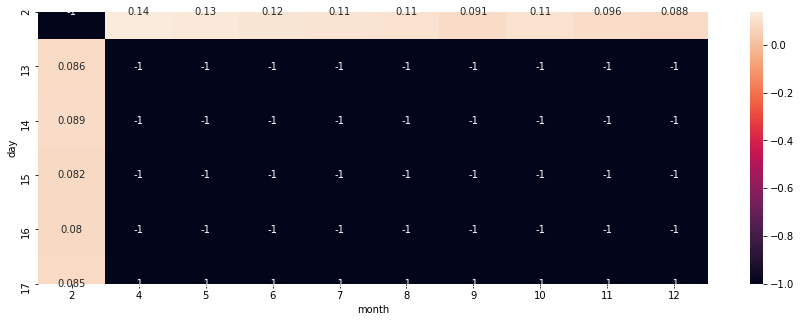

In [7]:
# date_time data looks artificial because it includes dates from the future (hackathon was held in May 2020).
# Let's make a look at dates of first visit

df_temp = (df
             .groupby('user_id_64', as_index=False)
             .agg({'date_time':min, 'target':max, 'test':max})
             .assign(month = lambda x: x.date_time.apply(lambda y: y.month),
                     day = lambda x: x.date_time.apply(lambda y: y.day),
                     hour = lambda x: x.date_time.apply(lambda y: y.hour))
)

figsize(15, 5)
sns.heatmap(pd.pivot_table(df_temp[df_temp.test==0],
                           index='day',
                           columns='month',
                           values='target',
                           aggfunc=np.mean,
                           fill_value=-1),
            annot=True)

In [8]:
# Is there are any differences between train and test?

print('Train dataset. Number of visitors, %')
print(pd.pivot_table(df_temp[df_temp.test==0],
                             index='day',
                             columns='month',
                             values='target',
                             aggfunc=lambda x: round(100 * len(x) / df_temp[df_temp.test==0].shape[0], 2),
                             fill_value=0))
print()
print('Test dataset. Number of visitors, %')
print(pd.pivot_table(df_temp[df_temp.test==1],
                             index='day',
                             columns='month',
                             values='target',
                             aggfunc=lambda x: round(100 * len(x) / df_temp[df_temp.test==1].shape[0], 2),
                             fill_value=0))

Train dataset. Number of visitors, %
month    2     4    5     6     7     8     9    10    11    12
day                                                            
2      0.00  9.23  7.3  6.98  6.35  6.03  6.22  6.1  5.79  5.73
13     9.55  0.00  0.0  0.00  0.00  0.00  0.00  0.0  0.00  0.00
14     7.75  0.00  0.0  0.00  0.00  0.00  0.00  0.0  0.00  0.00
15     8.25  0.00  0.0  0.00  0.00  0.00  0.00  0.0  0.00  0.00
16     7.30  0.00  0.0  0.00  0.00  0.00  0.00  0.0  0.00  0.00
17     7.41  0.00  0.0  0.00  0.00  0.00  0.00  0.0  0.00  0.00

Test dataset. Number of visitors, %
month    2     4     5     6     7     8     9     10    11    12
day                                                              
2      0.00  9.75  7.32  6.97  6.28  6.22  6.36  5.92  5.87  5.47
13     9.63  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
14     7.59  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
15     7.85  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
16     7.52  0.00 

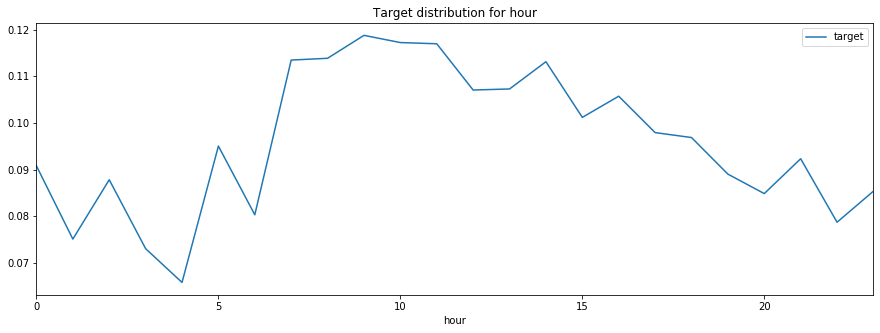

In [9]:
# So, the month of the first website visit is indeed an important feature.
# Now let's look at hour of the first visit

figsize(15, 5)
(df_temp[df_temp.test==0]
 .groupby('hour')
 .agg({'target':'mean'})
).plot(title='Target distribution for hour')

In [10]:
# Now let's have a look at number of sessions and their time

# numpy arrays for speed
user_ids = df[df.test==0].user_id_64.values
date_time = df[df.test==0].date_time.values
target = df[df.test==0].target.values

summary_user_id = []
summary_target = []
summary_n_sessions = []
summary_n_pages = []
summary_workday = []
summary_weekend = []
summary_night = []
summary_morning = []
summary_day = []
summary_evening = []

for user_id in tqdm(df[df.test==0].user_id_64.unique()):
    ind = np.where(user_ids == user_id)[0]
    
    summary_user_id.append(user_id)
    summary_target.append(max(target[ind]))
    summary_n_pages.append(len(ind))
    
    # all dates of website visits
    dates = np.sort(date_time[ind])
    # time difference between visits in hours
    dt = np.r_[np.array([0]), np.diff(dates) / np.timedelta64(1, 'h')]
    # indexes of different sessions where a break was more than 30 min
    dt_ind = np.r_[np.array([0]), np.where(dt > 0.5)[0], np.array(len(dates))]
    
    summary_n_sessions.append(len(dt_ind)-1)
    
    workday = 0
    weekend = 0
    night = 0
    morning = 0
    day = 0
    evening = 0
    
    # loop over sessions
    for i in dt_ind[:-1]:
        d = arrow.get(str(dates[i]))
        if d.format('dddd') not in ['Saturday', 'Sunday']:
            workday += 1
        else:
            weekend += 1
            
        if d.hour < 6:
            night += 1
        elif d.hour < 12:
            morning += 1
        elif d.hour < 18:
            day += 1
        else:
            evening += 1
            
    summary_workday.append(workday)
    summary_weekend.append(weekend)
    summary_night.append(night)
    summary_morning.append(morning)
    summary_day.append(day)
    summary_evening.append(evening)
    
all_data = (pd.DataFrame(summary_user_id, columns=['user_id'])
            .assign(target = summary_target,
                    n_sessions = summary_n_sessions,
                    n_pages = summary_n_pages,
                    workday = summary_workday,
                    weekend = summary_weekend,
                    night = summary_night,
                    morning = summary_morning,
                    day = summary_day,
                    evening = summary_evening
                   )
           )

print(all_data.shape)
all_data.head(3)

100%|██████████| 41120/41120 [07:09<00:00, 95.75it/s] 

(41120, 10)


,user_id,target,n_sessions,n_pages,workday,weekend,night,morning,day,evening
0,'1',0,1,14,1,0,0,0,0,1
1,'100',0,1,12,0,1,0,0,1,0
2,'1000',0,1,17,1,0,0,0,0,1


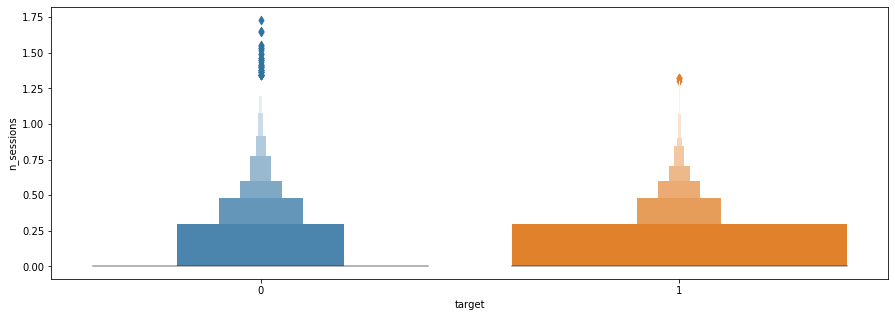

In [11]:
sns.boxenplot(data=all_data.assign(n_sessions=lambda x: x.n_sessions.apply(lambda y: np.log10(y))),
              y='n_sessions', x='target')

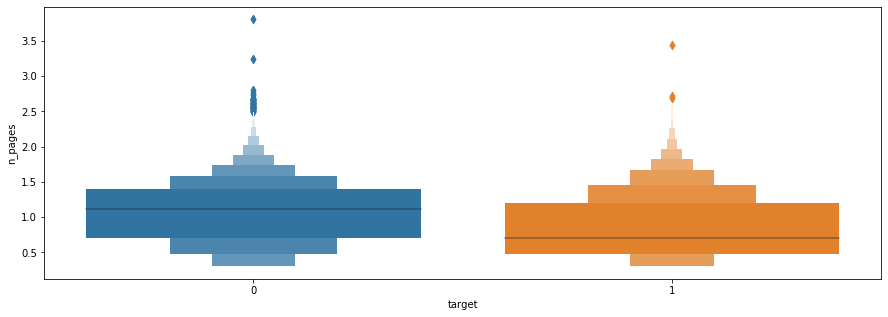

In [12]:
sns.boxenplot(data=all_data.assign(n_pages=lambda x: x.n_pages.apply(lambda y: np.log10(y))),
              y='n_pages', x='target')

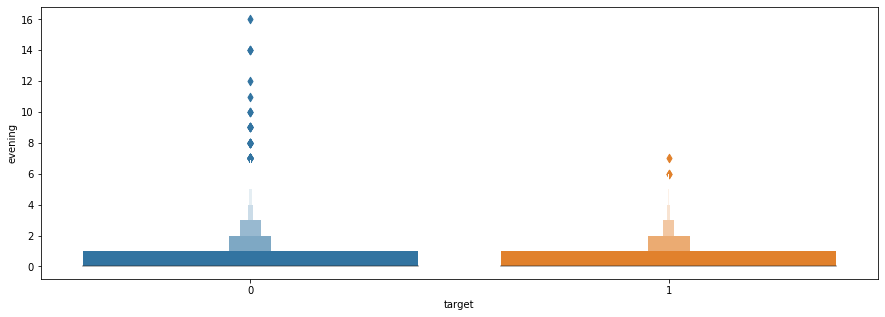

In [13]:
# All other columns for workday/weekend or night/morning/day/evening don't show any significant difference

sns.boxenplot(data=all_data, y='evening', x='target')

In [14]:
# So, finally, the following features should be created from the date_time column:
# - month of the first visit
# - hour of the first visit
# - n_sessions
# - n_pages

### event

In [15]:
# Distribution of event values in train and test (seems similar)

pd.crosstab(df.event, df.test, normalize=True)

test,0,1
event,,
AddPaymentInfo,9.959396e-07,0.000000
ItemView,6.446448e-01,0.159488
Lead,6.324216e-04,0.000147
PageView,1.565507e-01,0.038536


In [16]:
# Distribution of target in train

(df.loc[df.test==0, df.columns[~df.columns.isin(['target'])]]
 # define target vs user_id
 .merge(df[df.test==0].groupby('user_id_64', as_index=False).agg({'target':'max'}))
 .groupby('event', as_index=False)
 .agg({'target': 'mean'})
)

,event,target
0,AddPaymentInfo,1.000000
1,ItemView,0.072662
2,Lead,0.127559
3,PageView,0.099135


### event_value

In [17]:
df.event_value.value_counts()

0    1004077
Name: event_value, dtype: int64

### item_ids

In [18]:
pd.crosstab(df.item_ids, df.test)

test,0,1
item_ids,,
[':'],1350,467
['cdu09 cdu figo 2020.00:2020'],600,96
['cge07 c519 focus 2019.75:2019'],5309,1217
['ford :2017'],0,2
['ford b max:2012'],2,0
...,...,...
['new puma:undefined'],2,0
['new ranger:undefined'],15,0
['transit courier:2020'],2,0


### item_types

In [19]:
# count the number of target == 1 in the train dataset and find the same rows in the test

df[df.target==1].item_types.value_counts()

['brand:dealer locator']                                                 1555
['brand:owner:my vehicle:service booking:book service:select dealer']    1353
['brand:test drive:select vehicle']                                       485
['brand:checkout:dealer locator']                                         343
['brand:test drive:select dealer']                                        216
['brand:test drive:landing']                                               87
['brand:dealer contact request:contact details']                           65
['brand:dealer locator:results:pg 1']                                      28
['brand:error:404']                                                        13
['brand:dealer locator:error']                                              5
['brand:test drive:select dealer:results']                                  1
['brand:test drive:select vehicle & contact details']                       1
['brand:home:dealer locator:result']                            

In [20]:
# As we can see here, train and test datasets are different

df.loc[(df.test==1) & (df.item_types.isin(df[df.target==1].item_types.unique())), :].item_types.value_counts()

['brand:test drive:select dealer']            148
['brand:home:dealer locator:result']           48
['brand:test drive:select dealer:results']     45
['undefined']                                  10
Name: item_types, dtype: int64

### pixel_uuid

In [21]:
df.pixel_uuid.value_counts()

d4d09503-c83d-4e72-ac4b-5bb306b9525d    1004077
Name: pixel_uuid, dtype: int64

### segment_name

In [22]:
# count the number of target == 1 in the train dataset and find the same rows in the test

df[df.target==1].segment_name.value_counts()

UK_Owner_OSB Select Dealer                                    1353
UK_Dealer Search Complete_Headlights_Funnel_All Nameplates     606
UK_ Dealer Locator_FDR - Start                                 574
Ford- Focus Active- Find Dealer                                403
UK_Shop_Request-test-drive_all                                 379
UK_Checkout_Checkout - Find Dealer                             343
UK_Book a test drive_Headlights_ Funnel_All Nameplates         227
Ford- Focus Active- Test Drive Request Finish                  196
UK_dealer-locator_Contact Dealer - Select Vehicle               65
UK_Dealer Locator_FDR - Complete                                 7
Ford-Focus Active - Test Drive Start                             1
UK_dealer-locator_Contact Dealer - Contact details               1
Name: segment_name, dtype: int64

In [23]:
# So, it looks like in the test dataset all rows with target == 1 have been removed

df.loc[(df.test==1) & (df.segment_name.isin(df[df.target==1].segment_name.unique())), :].segment_name.value_counts()

Series([], Name: segment_name, dtype: int64)

#### Here the difference become much clearer (there are sertain segment_names which were removed from the test dataset). It means that we would need to train our models on the train dataset where target == 0 only

In [24]:
(pd.crosstab(df.segment_name, df.test)
 .assign(ratio = lambda x: x[1] / x[0])
 .sort_values('ratio', ascending=True)
)

test,0,1,ratio
segment_name,,,
UK_Book a test drive_Headlights_ Funnel_All Nameplates,227,0,0.000000
UK_Checkout_Checkout - Make Payment Start (Test),1,0,0.000000
UK_Dealer Locator_FDR - Complete,7,0,0.000000
UK_Dealer Search Complete_Headlights_Funnel_All Nameplates,606,0,0.000000
UK_ Dealer Locator_FDR - Start,574,0,0.000000
...,...,...,...
UK_Brochures Listing_Headlights_Funnel_All nameplates,7448,2221,0.298201
UK_Ford Account_Account - Marketing Permissions,146,45,0.308219
UK_Ford Account_Account - Register complete (Test Lead),107,33,0.308411


### Process all data

So, I decided to use the following columns:
 - date_time (month, hour, n_sessions, n_pages)
 - event (as text feature)
 - item_ids (number of unique ids)
 - item_types (as text feature)
 - conversion_pixel_id (as text feature)
 - segment_name (as text feature)
 - http_referer (extract some values from the referer_list, as text feature)

In [25]:
referer_list = ['android', 'mail.', 'google', 'instagram', 'yahoo',
                'bing', 'facebook', 'linkedin', 'youtube', 'twitter',
                'mdn', 'service', 'topgear', 'motor',  'forum', 'sale',
                'outlook', 'repair', 'ordering', 'baidu', 'offer', 'dealer']


### Lists to store aggregated data
summary_user_ids = []
summary_target = []
summary_test = []

summary_n_sessions = []
summary_n_pages = []
summary_month = []
summary_hour = []

summary_item_ids_unique = []
summary_event = []
summary_text_conversion_pixels = []
summary_text_other = []
summary_referer_domains = []


### Numpy arrays
d_user_id_64 = df.user_id_64.values
d_target = df.target.values
d_test = df.test.values

d_date_time = df.date_time.values
d_event = df.event.values
d_item_ids = df.item_ids.values
d_conversion_pixel_ids = df.conversion_pixel_ids.values
d_item_types = df.item_types.values
d_segment_name = df.segment_name.values
d_referer = df.http_referer.values

def process_user_id_new(user_id):
    ind = np.where(d_user_id_64 == user_id)[0]
    
    # user_ids, target and test
    summary_user_ids.append(user_id)
    summary_target.append(d_target[ind].max())
    summary_test.append(d_test[ind].max())
    
    # !!! remove all lines with target==1
    ind = ind[np.where(d_target[ind] != 1)[0]]
    
    summary_n_pages.append(len(ind))
    
    # all dates of website visits
    dates = np.sort(d_date_time[ind])
    # time difference between visits in hours
    dt = np.r_[np.array([0]), np.diff(dates) / np.timedelta64(1, 'h')]
    # indexes of different sessions where a break was more than 30 min
    dt_ind = np.r_[np.array([0]), np.where(dt > 0.5)[0], np.array(len(dates))]
    
    summary_n_sessions.append(len(dt_ind)-1)
    
    summary_month.append(arrow.get(str(dates[0])).month)
    summary_hour.append(arrow.get(str(dates[0])).hour)
    
    # number of unique item_ids
    summary_item_ids_unique.append(len(set(d_item_ids[ind])))
    
    # prepare conversion pixels text
    summary_text_conversion_pixels.append(' '.join([x[1:-1] for x in d_conversion_pixel_ids[ind] if x != '[]']))
    
    # prepare other text
    item_types = (" ".join([str(x[1:-1]) for x in d_item_types[ind]])
                  .lower()
                  .replace(':', ' ')
                  .replace("'", "")
                  .replace('brand ', '')
                 )
    segment_name = (" ".join([x for x in d_segment_name[ind] if x != 'Unknown/No Segment'])
                    .lower()
                    .replace(' & ', ' ')
                    .replace('_', ' ')
                    .replace('uk', '')
                   )
    summary_text_other.append(item_types + ' ' + segment_name)
    
    # prepare event
    summary_event.append(" ".join([x for x in d_event[ind]]))
    
    # referrer
    summary_referer_domains.append(" ".join([" ".join([x for x in referer_list if x in r]) for r in d_referer[ind] if type(r)==str]))
    
### Execution
for user_id in tqdm(df.user_id_64.unique()):
    process_user_id_new(user_id)
    
all_data = (pd.DataFrame(summary_user_ids, columns=['user_id'])
            .assign(target = summary_target,
                    test = summary_test,
                    n_sessions = summary_n_sessions,
                    n_pages = summary_n_pages,
                    month = summary_month,
                    hour = summary_hour,
                    item_ids_unique = summary_item_ids_unique,
                    event = summary_event,
                    conversion_pixels = summary_text_conversion_pixels,
                    text_other = summary_text_other,
                    referer_domains = summary_referer_domains,
                    )
           )

all_data.head()

100%|██████████| 51400/51400 [11:16<00:00, 76.02it/s]


,user_id,target,test,n_sessions,n_pages,month,hour,item_ids_unique,event,conversion_pixels,text_other,referer_domains
0,'1',0,0,1,14,6,20,1,ItemView ItemView ItemView ItemView ItemView I...,1188221 1188221,build intro build model build battery bp conte...,facebook facebook facebook facebook facebook f...
1,'100',0,0,1,12,5,12,1,ItemView PageView ItemView ItemView ItemView I...,1188214 1188214 1188221 1188221,build initiate build initiate build engine bui...,
2,'1000',0,0,1,17,2,23,3,ItemView ItemView PageView PageView ItemView I...,1188214 1188214 1188214 1188214 1207811 120781...,build initiate build initiate build initiate b...,
3,'10000',0,0,3,21,2,14,4,ItemView PageView ItemView ItemView PageView I...,1188214 1188214 1188214 1188214 1188214 118821...,build initiate build initiate build engine bui...,google google google
4,'10002',0,0,1,10,2,19,2,PageView PageView PageView PageView PageView P...,1207811 1207811 1207811 1207811 1207811 120781...,home home home home home home home home showro...,android google android google android google a...


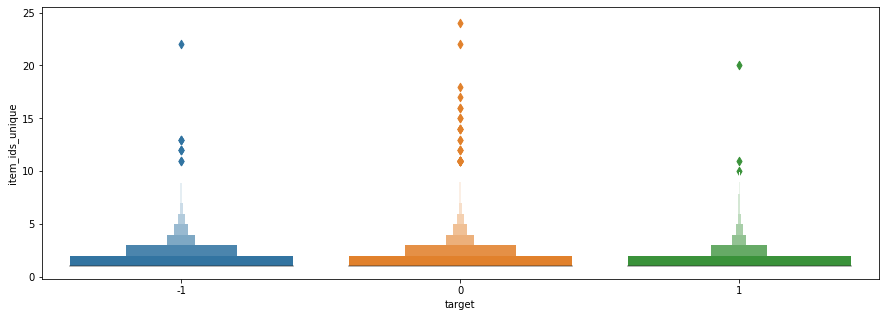

In [26]:
# Prove that item_ids_unique might be an important feature (target == -1 is for the test dataset)

sns.boxenplot(data=all_data,
              y='item_ids_unique', x='target')

In [27]:
all_data.to_hdf('all_data.h5', 'data')